# Transfer learning for enabling quality predictions in small batch production

This jupyter notebook is part of the publication "Transfer learning for enabling quality prediction in small batch production" a the CIRP ICME 24 conference. The notebook is a small excerpt from the developed framework. Many simplifications have been made, such as the data preprocessing and the network architecture of the based model. The notebook serves to make the procedure described in the paper easier to understand. The complete framework is subject to ongoing development and will be published at a later date. 

# Imports

In [1]:
from joblib import load

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchinfo import summary

# General functionalities and methods

In [2]:
class SimpleNN(nn.Module):
    """
    SimpleNN

    This class implements a simple feedforward neural network using PyTorch's nn.Module. It takes an input size and output size as arguments and creates a neural network with three hidden
    * layers.

    Parameters:
        - input_size (int): The number of input features
        - output_size (int): The number of output classes

    Methods:
        - forward(x): Performs a forward pass through the network

    Example usage:

    input_size = 10
    output_size = 5
    model = SimpleNN(input_size, output_size)
    input_data = torch.randn(1, input_size)
    output = model.forward(input_data)
    print(output)

    Note: This class requires the `torch` and `torch.nn` modules in order to work properly.
    """
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [3]:
def train_model(network, train_dataloader, val_dataloader, epochs):
    """
    Train Model

    Trains a neural network model using the provided training and validation datasets for a specified number of epochs.

    Parameters:
      - network (object): The neural network object containing the model, loss function, optimizer, and device.
      - train_dataloader (DataLoader): The dataloader for the training dataset.
      - val_dataloader (DataLoader): The dataloader for the validation dataset.
      - epochs (int): The number of epochs to train the model for.

    Returns:
      - train_losses (list): A list of training losses for each epoch.
      - val_losses (list): A list of validation losses for each epoch.
      - state_dicts (list): A list of model state dictionaries for each epoch.
    """
    model = network.model
    loss_fn = network.loss_fn
    optimizer = network.optimizer
    device = network.device
    
    model = model.to(device)
    state_dicts = [] #storing models of differnet epochs
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        
        train_loss = 0.0

        # Training loop
        for inputs, targets, *_ in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            train_loss += loss.item() * inputs.size(0)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, *_ in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_dataloader.dataset)
        val_loss = val_loss / len(val_dataloader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        state_dicts.append(model.state_dict())
    return train_losses, val_losses, state_dicts

In [4]:
class DataFrameDataset(Dataset):
    """
    Initializes a DataFrameDataset object.

    Args:
        features (pd.DataFrame): The feature columns.
        targets (pd.Series): The target column.
        scaler (sklearn.preprocessing.Scaler): The scaler object used to transform the features.
        identifiers (pd.Series): The identifier column.
    """
    def __init__(self, features, targets, scaler, identifiers):
        self.features = torch.tensor(scaler.transform(features), dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32).unsqueeze(1)
        self.identifiers = torch.tensor(identifiers.values, dtype=torch.int64)
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.identifiers[idx]

In [5]:
def get_dataloader_as_df(dataloader):
    """
    Converts a DataLoader object into a pandas DataFrame.

    Args:
        dataloader (torch.utils.data.DataLoader): The DataLoader object containing the data.

    Returns:
        pandas.DataFrame: The converted data as a DataFrame.

    """
    data_list = []
    # Assume your DataLoader is named 'data_loader'
    for batch in dataloader:
        # Assume each batch contains features and targets
        features, targets, identifiers = batch
        # Convert tensors to numpy arrays if they're not already
        features_np = features.numpy()
        targets_np = targets.numpy().reshape(-1, 1)  # Reshape targets to match feature shape if necessary
        identifiers_np = identifiers.numpy()  # Convert identifiers to numpy array
        
        # Combine features and targets
        combined = np.hstack((identifiers_np.reshape(-1, 1), features_np, targets_np))
        
        # Append this batch's data to our list
        # Note: Adjust this part if your data structure is different
        for row in combined:
            data_list.append(row)
    
    # Convert the list of arrays to a DataFrame
    # Adjust column names as necessary
    column_names = ['identifier'] + [f'feature_{i}' for i in range(features_np.shape[1])] + ['target']
    df = pd.DataFrame(data_list, columns=column_names)
    return df

In [6]:
def drop_datapoint_by_index(dataloader, df_to_drop_in):
    """
    Drops datapoints from a dataframe based on the indexes provided by a dataloader.

    Parameters:
    dataloader (object): The dataloader object that contains the indexes of datapoints to be dropped.
    df_to_drop_in (DataFrame): The dataframe from which the datapoints will be dropped.

    Returns:
    DataFrame: A new dataframe with the specified datapoints dropped.

    """
    df_to_drop_by = get_dataloader_as_df(dataloader)
    drop_indexes = list(df_to_drop_by['identifier'])
    return df_to_drop_in.drop(drop_indexes)

In [7]:
def split_dataframe_to_dataloaders(df, split_row, target_column, batch_size=32, in_scaler=None, val_only=False):
    """

    Split the given DataFrame into train and validation DataLoaders.

    Parameters:
    - df (DataFrame): The DataFrame to be split.
    - split_row (int): The index of the row to split the DataFrame.
    - target_column (str): The name of the target column.
    - batch_size (int, optional): The batch size for the DataLoaders. Defaults to 32.
    - in_scaler (Scaler, optional): An optional input scaler instance. Defaults to None.
    - val_only (bool, optional): Flag indicating whether to generate only a validation DataLoader. Defaults to False.

    Returns:
    - train_loader (DataLoader): The DataLoader for the training data.
    - val_loader (DataLoader): The DataLoader for the validation data. (Returned only if 'val_only' is False)
    - scaler (Scaler): The scaler instance used for feature scaling.

    """
    # Split the DataFrame
    validation_data_ratio = 0.2
    available_products = df.iloc[:split_row]
    
    if val_only:
        products_from_last_step = available_products.tail(DATA_STEP) #this are the data form last Datastep where no 
        # real measurements are available for
        X_train, y_train, train_index = (products_from_last_step.drop(columns=[target_column]), 
                             products_from_last_step[target_column], products_from_last_step.index)
    else:
        train_df, val_df = train_test_split(available_products, test_size=validation_data_ratio, shuffle=False)
       
        # Separate features and targets
        X_train, y_train, train_index = train_df.drop(columns=[target_column]), train_df[target_column], train_df.index
        X_val, y_val, val_index = val_df.drop(columns=[target_column]), val_df[target_column], val_df.index
    
    if not in_scaler:
        #train new scaler for train data of first product
        scaler = StandardScaler()
        scaler.fit(X_train)
        
    else: 
        scaler = in_scaler
        
    # Create datasets
    train_dataset = DataFrameDataset(X_train, y_train, scaler, train_index)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    
    if not val_only:
        val_dataset = DataFrameDataset(X_val, y_val, scaler, val_index)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        return train_loader, val_loader, scaler
    return train_loader

In [8]:
def list_of_dataframes_to_list_of_dataloaders(dataframes:list, num_of_train_values:int)-> list:
    """

    Converts a list of pandas dataframes to a list of PyTorch dataloaders.

    Parameters:
    - dataframes (list): A list of pandas dataframes.
    - num_of_train_values (int): The number of values to be used for training.

    Returns:
    - list: A list of dictionaries containing the PyTorch dataloaders. Each dictionary contains the keys 'train_loader' and 'val_loader'.

    """
    list_of_dataloaders = []
    scaler = None
    for index, dataframe in enumerate(dataframes):        
        train_loader, val_loader, scaler = split_dataframe_to_dataloaders(dataframe, num_of_train_values,
                                                                          target_column, in_scaler=scaler)
        list_of_dataloaders.append({"train_loader": train_loader, "val_loader": val_loader})
    return list_of_dataloaders

In [9]:
class NN:
    """

    The NN class is a wrapper class that encapsulates a simple neural network model, loss function, optimizer, and device to be used for training.

    Attributes:
    - model: A SimpleNN object representing the neural network model.
    - loss_fn: A torch.nn loss function object used to compute the loss during training.
    - optimizer: An optimizer object used to update the model parameters during training.
    - device: A device object representing the compute device (CPU or GPU) to be used for training.

    Methods:
    - __init__(): Initializes the NN class by creating a new SimpleNN model, a loss function, an optimizer, and selecting the appropriate device based on the availability of a GPU.
    - reset(model_state_dict): Resets the NN class by creating a new SimpleNN model and loading the given model_state_dict. If no model_state_dict is provided, the class will use the INITIAL
    *_STATE_DICT constant.
    - set_optimizer(new_lr): Sets the optimizer's learning rate for different layers of the model. The learning rate for fc4 and fc3 layers will be new_lr, while the learning rate for fc
    *2 and fc1 layers will be new_lr/10.

    Note: The class assumes the presence of the SimpleNN class, nn.MSELoss class, optim.Adam class, INITIAL_STATE_DICT constant, and torch module.

    """
    def __init__(self):
        self.model = SimpleNN(input_size=5, output_size=1)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def reset(self, model_state_dict):
        self.model = SimpleNN(input_size=5, output_size=1)
        if not model_state_dict:
            model_state_dict = INITIAL_STATE_DICT
        self.model.load_state_dict(model_state_dict)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
    def set_optimizer(self, new_lr):
        params = [
            {'params': self.model.fc4.parameters(), 'lr': new_lr},
            {'params': self.model.fc3.parameters(), 'lr': new_lr},
            {'params': self.model.fc2.parameters(), 'lr': new_lr/10},
            {'params': self.model.fc1.parameters(), 'lr': new_lr/10}
        ]
        self.optimizer = optim.Adam(params)

In [10]:
def plot_no_prod_for_training_validation(statistics, ylim=None, inspection_step: int = 5, x_label:str = "", 
                                         coloring:bool=False, text_y_position: int = -0.03):
    """

    Plot the number of products used for training and the minimum validation loss for each product.

    Parameters:
    - statistics: List of dictionaries. Each dictionary represents the statistics for a product. The dictionary should have the following keys:
        - 'product_id': A string representing the product ID.
        - 'num_of_products_used_for_training': A list of integers representing the number of products used for training.
        - 'min_val_loss_on_training': A list of floats representing the minimum validation loss for each training.

    - ylim: Optional. Integer representing the upper limit for the y-axis. If not provided, the y-axis will be scaled automatically.

    - inspection_step: Optional. Integer representing the step size for subsampling the statistics. Default value is 5.

    - x_label: Optional. String representing the label for the x-axis. Default value is an empty string.

    - coloring: Optional. Boolean indicating whether to color the data points based on whether the validation loss is below a threshold. Default value is False.

    - text_y_position: Optional. Integer representing the y-position of the x-label. Default value is -0.03.

    Returns:
    - None

    """
    statistics = statistics[::inspection_step]
    # Create subplots that share the y-axis
    fig, axs = plt.subplots(1, len(statistics), sharey=True, figsize=(len(statistics) * 3, 3))
        
    for product, value in enumerate(statistics):
        if coloring: 
            colors = ['green' if y < LOSS_REQUIRED else 'blue' for y in value['min_val_loss_on_training']]
        else:
            colors = ['blue']*len(value['min_val_loss_on_training'])
        axs[product].scatter(value['num_of_products_used_for_training'], value['min_val_loss_on_training'], c=colors)
        axs[product].set_title(value['product_id'])
        axs[product].axhline(y=LOSS_REQUIRED, color='y', linestyle=':', linewidth=2)
    
    # Set a common y-label
    axs[0].set_ylabel('val loss')
    if ylim:
        axs[0].set_ylim([0,ylim])
    
    fig.text(0.5, text_y_position, x_label, ha='center')
    fig.subplots_adjust(wspace=0)
        
    plt.show()

In [11]:
def find_first_below(lst, search_value):
    """

        This method finds the index of the first element in the given list that is below the specified search value.

        :param lst: The list to search in.
        :type lst: list
        :param search_value: The value to search for.
        :type search_value: int
        :return: The index of the first element below the search value, or None if no such element exists.
        :rtype: int or None
    """
    for i, value in enumerate(lst):
        if value < search_value:
            return i  # Return the index as soon as a value below x is found
    return None  # Return None if no such value exists

# General strategy settings and loading data

In [13]:
EPOCHS = 400
LOSS_REQUIRED = 500 #a value below the needed model accuracy with some safety margain
DATA_STEP = 20 #how much datapoints should be added each training loop
tmp_model = NN()
INITIAL_STATE_DICT = tmp_model.model.state_dict() #stat_dict of model that each strategy starts on

products_df = load("../data/artificial_data.joblib")
feature_columns = ['Temperature', 'Pressure', 'Speed', 'Time','MaterialQuality'] # Modify as needed
target_column = 'Quality'

# Strategy 1: Control/Reference Model
Normal training where each product gets its own model trained from scratch (same architecture) -> 
reference model

In [14]:
def train_on_different_amount_of_datapoints_strategy1(dataframe):
    """
    Train a neural network model on different amounts of data points using strategy 1.

    Args:
        dataframe (pandas.DataFrame): The input dataframe containing the data points.

    Returns:
        dict: A dictionary containing the following information:
            - num_of_products_used_for_training (range): The range of number of products used for training.
            - min_val_loss_on_training (list): The minimum validation loss achieved during training.
            - min_val_loss_models (list): The models corresponding to the minimum validation loss.
            - train_losses (list): The training losses at each iteration.
            - val_losses (list): The validation losses at each iteration.
            - active_trainings (list): The status of each training (True for active).
    """
    min_val_losses = []
    models_of_min_val_losses = []
    train_losses, val_losses = [], []
    num_of_products_to_use = range(10, dataframe.shape[0], DATA_STEP)
    model = NN()
    
    for index, num_of_products_in_train in enumerate(num_of_products_to_use):
        model.reset(model_state_dict=None) #set the Model to INITIAL_STATE_DICT and reset optimizer accordingly

        # model_summary = summary(model.model,
        #                             input_size=(32, 5),
        #                             col_names=["input_size", "output_size", "num_params", "trainable"])
        # print(model_summary)

        train_loader, val_loader, scaler = split_dataframe_to_dataloaders(dataframe, num_of_products_in_train,
                                                   target_column,  in_scaler = None)
        train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS)
        
        min_val_loss = min(val_loss) #get the epoch with best validation loss
        min_val_losses.append(min_val_loss)
        models_of_min_val_losses.append(
            model_states[val_loss.index(min_val_loss)] #get model for epoch with best validation loss
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
    return {
        "num_of_products_used_for_training": num_of_products_to_use,
        "min_val_loss_on_training": min_val_losses,
        "min_val_loss_models": models_of_min_val_losses,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "active_trainings": [True]*len(min_val_losses)
    }

In [15]:
strategy1 = []
for index, product in enumerate(products_df):
    model_statistic = train_on_different_amount_of_datapoints_strategy1(product)
    model_statistic['product_id'] = index + 1
    strategy1.append(model_statistic)

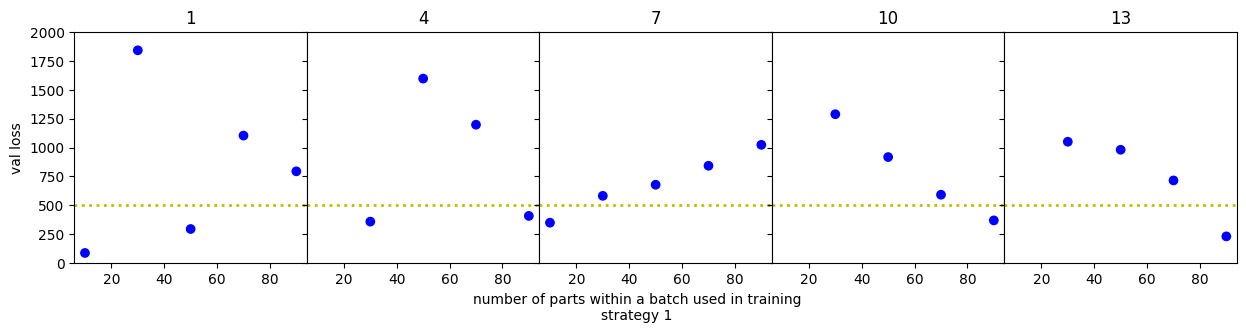

In [16]:
plot_no_prod_for_training_validation(strategy1, ylim=2000, 
                                     inspection_step=3, 
                                     x_label="number of parts within a batch used in training\n"
                                             "strategy 1", 
                                     coloring=False, text_y_position=-0.08)

# Strategy 2: Frozen model strategy

Using the same strategy as strategy 2; only difference is that the lower layers in subsequent model is frozen before training. Only the upper layers are trained. 

In [31]:
def train_on_different_amount_of_datapoints_strategy2(dataframe, model_state_dict=None, in_scaler=None, 
                                                      freeze_lower_layers=False):
    """
    Train on Different Amount of Data Points Strategy 2

    Trains a model on different amounts of data points and calculates the best validation loss in training.

    Args:
        dataframe (pandas.DataFrame): The input dataframe containing the data points.
        model_state_dict (dict, optional): The state dictionary of the model. Defaults to None.
        in_scaler (Any, optional): The input scaler. Defaults to None.
        freeze_lower_layers (bool, optional): Whether to freeze the lower layers of the model. Defaults to False.

    Returns:
        tuple: A tuple containing the results of the training and the scaler used.

    Example:
        train_data, scaler = train_on_different_amount_of_datapoints_strategy2(dataframe, model_state_dict=model_state_dict, in_scaler=in_scaler, freeze_lower_layers=True)
    """
    #use different (ordered) amount of data for training and calculate best validation loss in trainng
    min_val_losses = []
    models_of_min_val_losses = []
    train_losses, val_losses = [], []
    active_trainigs = []
    num_of_datapoints_to_use = range(10, dataframe.shape[0], DATA_STEP)
    num_of_dropped_datapoints = 0
    
    model = NN()
    for i, num_of_datapoints_in_train in enumerate(num_of_datapoints_to_use):
        ''' Correction of num_of_datapint_in_train needed after dropping values from dateaframe otherwise the indexer
         is wrong since data is getting shifted in the original dataset
        '''
        num_of_datapoints_in_train -= num_of_dropped_datapoints
        train_loader, val_loader, scaler = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler)

        if not min_val_losses or not min_val_losses[-1] < LOSS_REQUIRED: #train model with data from manual inspection
            model.reset(model_state_dict) #set the Model to INITIAL_STATE_DICT and reset optimizer accordingly
            
            if freeze_lower_layers:
                # Freeze lower layers if required
                for param in model.model.fc1.parameters():
                    param.requires_grad = False
                for param in model.model.fc2.parameters():
                    param.requires_grad = False
            train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS)
            
            min_val_loss = min(val_loss) #get the epoch with best validation loss
            models_of_min_val_losses.append(  #get model for epoch with best validation loss
                model_states[val_loss.index(min_val_loss)])
            train_losses.append(train_loss)
            active_trainigs.append(True)
        else: #don't train further but check if validations are still in required limits of loss
            #load newly added data | last DATA-STEP 
            val_loader = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler, val_only=True)
            model.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets, *_ in val_loader:
                    inputs, targets = inputs.to(model.device), targets.to(model.device)
                    outputs = model.model(inputs)
                    loss = model.loss_fn(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

            # Calculate average losses
            val_loss = val_loss / len(val_loader.dataset)
            min_val_loss = val_loss
            models_of_min_val_losses.append(model.model.state_dict()) #no changes here, model from before
            train_losses.append([]) #no training in this loop
            active_trainigs.append(False)
            
            '''
            drop the last DATA_STEP since it has no real quality measuremnts and can not be used for later 
            later training
            '''
            
            dataframe = drop_datapoint_by_index(val_loader, dataframe)
            num_of_dropped_datapoints += DATA_STEP
        
        min_val_losses.append(min_val_loss)
        val_losses.append(val_loss)
            
        
    return {
        "num_of_products_used_for_training": num_of_datapoints_to_use,
        "min_val_loss_on_training": min_val_losses,
        "min_val_loss_models": models_of_min_val_losses,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "active_trainings": active_trainigs
    }, scaler

In [32]:
strategy2 = []
for index, product in enumerate(products_df):
    if index == 0: #train on new model
        model_statistic, scaler = train_on_different_amount_of_datapoints_strategy2(product)
    else: #reuse model from previous product
        index_from_previous_product = find_first_below(strategy2[-1]['min_val_loss_on_training'], LOSS_REQUIRED)
        if index_from_previous_product:
            model_states_from_previous_product = strategy2[-1]['min_val_loss_models'][index_from_previous_product]
        else:
            model_states_from_previous_product = strategy2[-1]['min_val_loss_models'][-1]
        model_statistic, *_ = train_on_different_amount_of_datapoints_strategy2(product,
                                                                    model_state_dict=model_states_from_previous_product,
                                                                    in_scaler=scaler,
                                                                    freeze_lower_layers=True)
    model_statistic['product_id'] = index + 1
    strategy2.append(model_statistic)

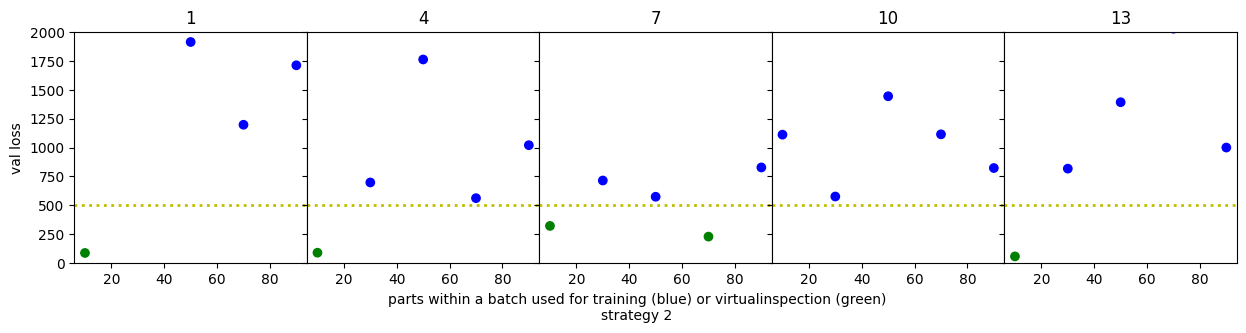

In [33]:
plot_no_prod_for_training_validation(strategy2, ylim=2000, 
                                     inspection_step=3, 
                                     x_label="parts within a batch used for training (blue) or virtual"
                                             "inspection (green)\n"
                                             "strategy 2", 
                                     coloring=True, text_y_position=-0.08)

# Strategy 3: Soft Start Model (from H. Tercan)
Training where each model is training on the trained model from the product before. The training of the products is 
stopped once a certain loss criteria (that defines model can go into deployment) is met.

In [34]:
def train_on_different_amount_of_datapoints_strategy3(dataframe, model_state_dict=None, in_scaler=None):
    """
    Train the model on different amounts of datapoints using strategy 3.

    Parameters:
    dataframe (DataFrame): The input dataframe to train on.
    model_state_dict (dict, optional): The state dictionary of the model. Defaults to None.
    in_scaler (Scaler, optional): The input scaler. Defaults to None.

    Returns:
    dict, Scaler: A dictionary containing the training details and the scaler used.
    """
    min_val_losses = []
    models_of_min_val_losses = []
    train_losses, val_losses = [], []
    active_trainigs = []
    num_of_datapoints_to_use = range(10, dataframe.shape[0], DATA_STEP)
    num_of_dropped_datapoints = 0
    
    model = NN()
    for i, num_of_datapoints_in_train in enumerate(num_of_datapoints_to_use):
        ''' Correction of num_of_datapint_in_train needed after dropping values from dateaframe otherwise the indexer
         is wrong since data is getting shifted in the original dataset
        '''
        num_of_datapoints_in_train -= num_of_dropped_datapoints
        train_loader, val_loader, scaler = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler)

        if not min_val_losses or not min_val_losses[-1] < LOSS_REQUIRED: #train model with data from manual inspection
            model.reset(model_state_dict) #set the Model to INITIAL_STATE_DICT and reset optimizer accordingly
            
            train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS)
            
            min_val_loss = min(val_loss) #get the epoch with best validation loss
            models_of_min_val_losses.append(  #get model for epoch with best validation loss
                model_states[val_loss.index(min_val_loss)])
            train_losses.append(train_loss)
            active_trainigs.append(True)
        else: #don't train further but check if validations are still in required limits of loss
            #load newly added data | last DATA-STEP 
            val_loader = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler, val_only=True)
            model.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets, *_ in val_loader:
                    inputs, targets = inputs.to(model.device), targets.to(model.device)
                    outputs = model.model(inputs)
                    loss = model.loss_fn(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

            # Calculate average losses
            val_loss = val_loss / len(val_loader.dataset)
            min_val_loss = val_loss
            models_of_min_val_losses.append(model.model.state_dict()) #no changes here, model from before
            train_losses.append([]) #no training in this loop
            active_trainigs.append(False)
            
            '''
            drop the last DATA_STEP since it has no real quality measuremnts and can not be used for later 
            later training
            '''
            
            dataframe = drop_datapoint_by_index(val_loader, dataframe)
            num_of_dropped_datapoints += DATA_STEP
        
        min_val_losses.append(min_val_loss)
        val_losses.append(val_loss)
            
        
    return {
        "num_of_products_used_for_training": num_of_datapoints_to_use,
        "min_val_loss_on_training": min_val_losses,
        "min_val_loss_models": models_of_min_val_losses,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "active_trainings": active_trainigs
    }, scaler

In [35]:
strategy3 = []
for index, product in enumerate(products_df):
    if index == 0: #train on new model
        model_statistic, scaler = train_on_different_amount_of_datapoints_strategy3(product)
    else: #reuse model from previous product
        index_from_previous_product = find_first_below(strategy3[-1]['min_val_loss_on_training'], LOSS_REQUIRED)
        if index_from_previous_product:
            model_states_from_previous_product = strategy3[-1]['min_val_loss_models'][index_from_previous_product]
        else:
            model_states_from_previous_product = strategy3[-1]['min_val_loss_models'][-1]
        model_statistic, *_ = train_on_different_amount_of_datapoints_strategy3(product,
                                                                    model_state_dict=model_states_from_previous_product,
                                                                    in_scaler=scaler)
    model_statistic['product_id'] = index + 1
    strategy3.append(model_statistic)

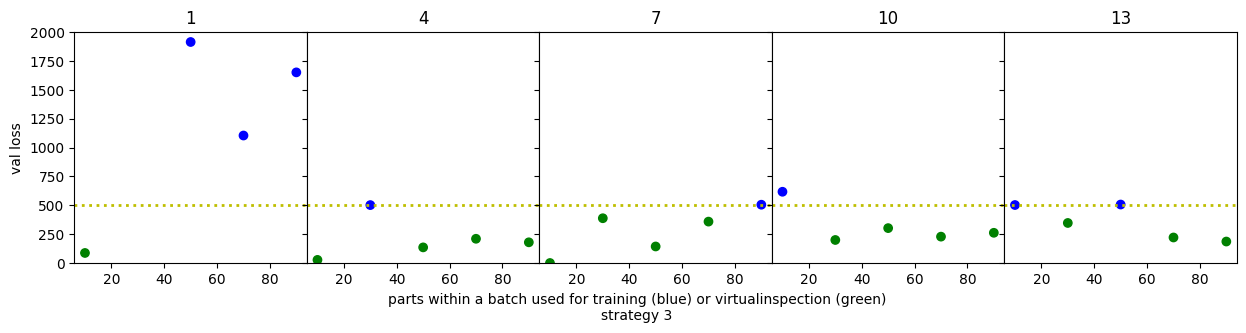

In [36]:
plot_no_prod_for_training_validation(strategy3, ylim=2000, 
                                     inspection_step=3, 
                                     x_label="parts within a batch used for training (blue) or virtual"
                                             "inspection (green)\n"
                                             "strategy 3", 
                                     coloring=True, text_y_position=-0.08)

# Strategy 4: Standard Fine Tune strategy

Using the same strategy as strategy 2; The weights of upper layers are reset and trained from scratch with a higher learning rate, whereas weights of lower layers are trained with lower learning rate. 

In [37]:
def train_on_different_amount_of_datapoints_strategy4(dataframe, model_state_dict=None, in_scaler=None, 
                                                      standard_fine_tune=False):
    """

    Train on Different Amount of Datapoints Strategy 4

    Trains a model using different amounts of datapoints, and applies a strategy to fine-tune the model based on validation loss. The strategy involves resetting the model to an initial
    * state, freezing lower layers if specified, and training the model on a subset of the training data. The process is repeated for different amounts of datapoints, and the model with
    * the lowest validation loss is saved.

    Parameters:
    - dataframe: The input dataframe containing the dataset.
    - model_state_dict: The state dictionary of the model. If provided, the model will be initialized with the provided state. Default is None.
    - in_scaler: The input scaler object to apply scaling transformations on the features. Default is None.
    - standard_fine_tune: A boolean flag indicating whether to freeze lower layers during standard fine-tuning. Default is False.

    Returns:
    A dictionary containing the following information:
    - "num_of_products_used_for_training": The list of number of datapoints used for training.
    - "min_val_loss_on_training": The list of minimum validation losses obtained during training.
    - "min_val_loss_models": The list of models corresponding to the minimum validation losses.
    - "train_losses": The list of training losses obtained during training.
    - "val_losses": The list of validation losses obtained during training.
    - "active_trainings": The list of boolean flags indicating whether the model was actively trained or not.

    Note: The returned scaler object can be used for inverse scaling of the features.

    """
    min_val_losses = []
    models_of_min_val_losses = []
    train_losses, val_losses = [], []
    active_trainigs = []
    num_of_datapoints_to_use = range(10, dataframe.shape[0], DATA_STEP)
    num_of_dropped_datapoints = 0
    
    model = NN()
    for i, num_of_datapoints_in_train in enumerate(num_of_datapoints_to_use):
        ''' Correction of num_of_datapint_in_train needed after dropping values from dateaframe otherwise the indexer
         is wrong since data is getting shifted in the original dataset
        '''
        num_of_datapoints_in_train -= num_of_dropped_datapoints
        train_loader, val_loader, scaler = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler)

        if not min_val_losses or not min_val_losses[-1] < LOSS_REQUIRED: #train model with data from manual inspection
            model.reset(model_state_dict) #set the Model to INITIAL_STATE_DICT and reset optimizer accordingly
            
            
            # print("Before reset\n", model.model.fc3.weight[0])
            if standard_fine_tune:
                # Freeze lower layers if required
                model.model.fc3.reset_parameters()
                model.model.fc4.reset_parameters()
                model.set_optimizer(0.005)
                # print("After reset")
                # print(model.model.fc4.weight[0])            

            # model_summary = summary(model.model,
            #                         input_size=(32, 5),
            #                         col_names=["input_size", "output_size", "num_params", "trainable"])
            # print(model_summary)
            # for i, param_group in enumerate(model.optimizer.param_groups):
            #     print(f"Learning rate for parameter group {i}: {param_group['lr']}")

            train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS)
            
            min_val_loss = min(val_loss) #get the epoch with best validation loss
            models_of_min_val_losses.append(  #get model for epoch with best validation loss
                model_states[val_loss.index(min_val_loss)])
            train_losses.append(train_loss)
            active_trainigs.append(True)
            
        else: #don't train further but check if validations are still in required limits of loss
            #load newly added data | last DATA-STEP 
            val_loader = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler, val_only=True)
            model.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets, *_ in val_loader:
                    inputs, targets = inputs.to(model.device), targets.to(model.device)
                    outputs = model.model(inputs)
                    loss = model.loss_fn(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

            # Calculate average losses
            val_loss = val_loss / len(val_loader.dataset)
            min_val_loss = val_loss
            models_of_min_val_losses.append(model.model.state_dict()) #no changes here, model from before
            train_losses.append([]) #no training in this loop
            active_trainigs.append(False)
            
            '''
            drop the last DATA_STEP since it has no real quality measuremnts and can not be used for later 
            later training
            '''
            
            dataframe = drop_datapoint_by_index(val_loader, dataframe)
            num_of_dropped_datapoints += DATA_STEP
        
        min_val_losses.append(min_val_loss)
        val_losses.append(val_loss)
            
        
    return {
        "num_of_products_used_for_training": num_of_datapoints_to_use,
        "min_val_loss_on_training": min_val_losses,
        "min_val_loss_models": models_of_min_val_losses,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "active_trainings": active_trainigs
    }, scaler

In [38]:
strategy4 = []
for index, product in enumerate(products_df):
    if index == 0: #train on new model
        model_statistic, scaler = train_on_different_amount_of_datapoints_strategy4(product)
    else: #reuse model from previous product
        index_from_previous_product = find_first_below(strategy4[-1]['min_val_loss_on_training'], LOSS_REQUIRED)
        if index_from_previous_product:
            model_states_from_previous_product = strategy4[-1]['min_val_loss_models'][index_from_previous_product]
        else:
            model_states_from_previous_product = strategy4[-1]['min_val_loss_models'][-1]
        model_statistic, *_ = train_on_different_amount_of_datapoints_strategy4(product,
                                                                    model_state_dict=model_states_from_previous_product,
                                                                    in_scaler=scaler,
                                                                    standard_fine_tune=True)
    model_statistic['product_id'] = index + 1
    strategy4.append(model_statistic)

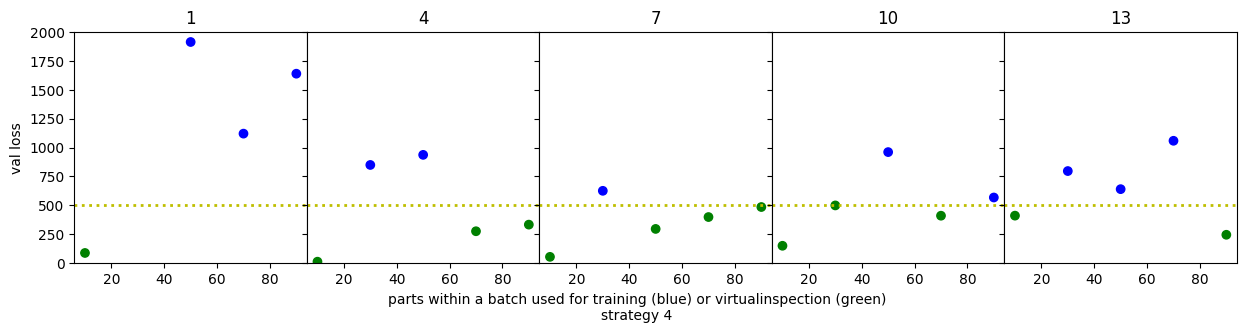

In [39]:
plot_no_prod_for_training_validation(strategy4, ylim=2000, 
                                     inspection_step=3, 
                                     x_label="parts within a batch used for training (blue) or virtual"
                                             "inspection (green)\n"
                                             "strategy 4", 
                                     coloring=True, text_y_position=-0.08)

# Strategy 5: Frozen Start Fine Tuning model strategy

Using the same strategy as strategy 2; only difference is that models are trained in following phases:
- Phase 1: Lower layers frozen, and upper layers trained.
- Phase 2: All layers are trained from endpoint of phase 1, with lower learning rate

In [40]:
def train_on_different_amount_of_datapoints_strategy5(dataframe, model_state_dict=None, in_scaler=None, 
                                                      phase_wise_training=False):
    """

    Trains a neural network model on different amounts of data points using strategy 5.

    :param dataframe: The input DataFrame containing the data points.
    :param model_state_dict: (Optional) The state dictionary of the model. Defaults to None.
    :param in_scaler: (Optional) The input scaler. Defaults to None.
    :param phase_wise_training: (Optional) Flag indicating whether to use phase-wise training. Defaults to False.

    :return: A dictionary containing the following keys:
        - "num_of_products_used_for_training": The number of data points used for training in each iteration.
        - "min_val_loss_on_training": The minimum validation loss achieved in each iteration.
        - "min_val_loss_models": The models corresponding to the minimum validation loss in each iteration.
        - "train_losses": The training losses for each iteration.
        - "val_losses": The validation losses for each iteration.
        - "active_trainings": A boolean flag indicating whether a training was performed in each iteration.
        - scaler: The scaler used for scaling the data.

    """
    min_val_losses = []
    models_of_min_val_losses = []
    train_losses, val_losses = [], []
    active_trainigs = []
    num_of_datapoints_to_use = range(10, dataframe.shape[0], DATA_STEP)
    num_of_dropped_datapoints = 0
    
    model = NN()
    for i, num_of_datapoints_in_train in enumerate(num_of_datapoints_to_use):
        ''' Correction of num_of_datapint_in_train needed after dropping values from dateaframe otherwise the indexer
         is wrong since data is getting shifted in the original dataset
        '''
        num_of_datapoints_in_train -= num_of_dropped_datapoints
        train_loader, val_loader, scaler = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler)

        if not min_val_losses or not min_val_losses[-1] < LOSS_REQUIRED: #train model with data from manual inspection            
            if phase_wise_training: #Freezing of the lower layers
                model.reset(model_state_dict) #set the Model to INITIAL_STATE_DICT and reset optimizer accordingly

                # PHASE 1:
                # print("Starting Phase 1...")
                for param in model.model.fc1.parameters():
                    param.requires_grad = False
                for param in model.model.fc2.parameters():
                    param.requires_grad = False
                
                # model_summary = summary(model.model,
                #                         input_size=(32, 5),
                #                         col_names=["input_size", "output_size", "num_params", "trainable"])
                # print(model_summary)
                train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS//2)

                min_val_loss = min(val_loss) #get the epoch with best validation loss
                # Update model state for Phase 2 training
                model_state_dict = model_states[val_loss.index(min_val_loss)]  # Use the model state from the end of Phase 1

                # PHASE 2:
                # print("Starting Phase 2...")
                model.reset(model_state_dict)  # Reset model to the state at the end of Phase 1

                for param in model.model.fc1.parameters():
                    param.requires_grad = True
                for param in model.model.fc2.parameters():
                    param.requires_grad = True

                # model_summary = summary(model.model,
                #                         input_size=(32, 5),
                #                         col_names=["input_size", "output_size", "num_params", "trainable"])
                # print(model_summary)
                train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS//2)

                min_val_loss = min(val_loss) #get the epoch with best validation loss
                models_of_min_val_losses.append(  #get model for epoch with best validation loss
                    model_states[val_loss.index(min_val_loss)])
                train_losses.append(train_loss)
                active_trainigs.append(True)
                
            else:
                model.reset(model_state_dict) #set the Model to INITIAL_STATE_DICT and reset optimizer accordingly
                model_summary = summary(model.model,
                                        input_size=(32, 5),
                                        col_names=["input_size", "output_size", "num_params", "trainable"])
                print(model_summary)

                train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS)
                
                min_val_loss = min(val_loss) #get the epoch with best validation loss
                models_of_min_val_losses.append(  #get model for epoch with best validation loss
                    model_states[val_loss.index(min_val_loss)])
                train_losses.append(train_loss)
                active_trainigs.append(True)
                
        else: #don't train further but check if validations are still in required limits of loss
            #load newly added data | last DATA-STEP 
            val_loader = split_dataframe_to_dataloaders(dataframe, num_of_datapoints_in_train,
                                                       target_column,  in_scaler = in_scaler, val_only=True)
            model.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets, *_ in val_loader:
                    inputs, targets = inputs.to(model.device), targets.to(model.device)
                    outputs = model.model(inputs)
                    loss = model.loss_fn(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

            # Calculate average losses
            val_loss = val_loss / len(val_loader.dataset)
            min_val_loss = val_loss
            models_of_min_val_losses.append(model.model.state_dict()) #no changes here, model from before
            train_losses.append([]) #no training in this loop
            active_trainigs.append(False)
            
            '''
            drop the last DATA_STEP since it has no real quality measuremnts and can not be used for later 
            later training
            '''
            
            dataframe = drop_datapoint_by_index(val_loader, dataframe)
            num_of_dropped_datapoints += DATA_STEP
        
        min_val_losses.append(min_val_loss)
        val_losses.append(val_loss)
            
        
    return {
        "num_of_products_used_for_training": num_of_datapoints_to_use,
        "min_val_loss_on_training": min_val_losses,
        "min_val_loss_models": models_of_min_val_losses,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "active_trainings": active_trainigs
    }, scaler

In [41]:
strategy5 = []
for index, product in enumerate(products_df):
    if index == 0: #train on new model
        model_statistic, scaler = train_on_different_amount_of_datapoints_strategy5(product)
    else: #reuse model from previous product
        index_from_previous_product = find_first_below(strategy5[-1]['min_val_loss_on_training'], LOSS_REQUIRED)
        if index_from_previous_product:
            model_states_from_previous_product = strategy5[-1]['min_val_loss_models'][index_from_previous_product]
        else:
            model_states_from_previous_product = strategy5[-1]['min_val_loss_models'][-1]
        model_statistic, *_ = train_on_different_amount_of_datapoints_strategy5(product,
                                                                    model_state_dict=model_states_from_previous_product,
                                                                    in_scaler=scaler,
                                                                    phase_wise_training=True)
    model_statistic['product_id'] = index + 1
    strategy5.append(model_statistic)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleNN                                 [32, 5]                   [32, 1]                   --                        True
├─Linear: 1-1                            [32, 5]                   [32, 32]                  192                       True
├─ReLU: 1-2                              [32, 32]                  [32, 32]                  --                        --
├─Linear: 1-3                            [32, 32]                  [32, 32]                  1,056                     True
├─ReLU: 1-4                              [32, 32]                  [32, 32]                  --                        --
├─Linear: 1-5                            [32, 32]                  [32, 32]                  1,056                     True
├─ReLU: 1-6                              [32, 32]                  [32, 32]                  --                        --
├─Linear:

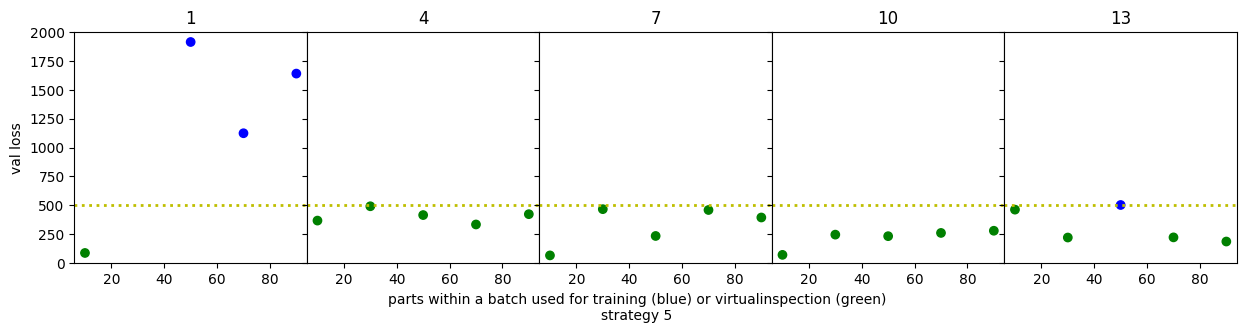

In [42]:
plot_no_prod_for_training_validation(strategy5, ylim=2000, 
                                     inspection_step=3, 
                                     x_label="parts within a batch used for training (blue) or virtual"
                                             "inspection (green)\n"
                                             "strategy 5", 
                                     coloring=True, text_y_position=-0.08)

# Strategy Comparisment

In [43]:
strat_eval = list()
for strategy in [strategy1, strategy2, strategy3, strategy4, strategy5]:
    strat_losses = []
    for i, strat in enumerate(strategy):
        strat_losses.extend(strat['min_val_loss_on_training'])
    man_insp = len([i for i in strat_losses if i > 500])
    virt_insp = len([i for i in strat_losses if i <= 500])
    strat_eval.append({
        "man_insp": man_insp,
        "virt_insp": virt_insp
    })

In [44]:
for i, value in enumerate(strat_eval):
    print(f"strategy{i}:")
    print(f"man_insp: {value['man_insp']}\n"
          f"virt_insp: {value['virt_insp']}\n")

strategy0:
man_insp: 57
virt_insp: 18

strategy1:
man_insp: 52
virt_insp: 23

strategy2:
man_insp: 19
virt_insp: 56

strategy3:
man_insp: 28
virt_insp: 47

strategy4:
man_insp: 13
virt_insp: 62


# Standard PQ-Approach
Commonly applied procedure in production: Collect as many datapoints of as many products till loss criteria is met 
and than deploy model.

In [55]:
all_products = pd.concat(products_df)
min_val_losses = []
steadiness = 0
steadiness_check = False
for number_of_used_datapoints in range(10, len(all_products), DATA_STEP):
    model = NN()
    model.reset(model_state_dict=None)

    train_loader, val_loader, scaler = split_dataframe_to_dataloaders(all_products, number_of_used_datapoints,
                                                   target_column)
    train_loss, val_loss, model_states = train_model(model, train_loader, val_loader, EPOCHS)
    min_val_losses.append({
        "y": min(val_loss),
        "x": number_of_used_datapoints
    })
    
    if min(val_loss) <= LOSS_REQUIRED:
        if steadiness_check:
            steadiness += 1
            print(f"steadiness check raised: {steadiness} at {number_of_used_datapoints} Datapoints")
        else:
            steadiness_check = True
            print("good loss score detected")
    elif steadiness_check:
        steadiness_check = False
        print("damn.. model bad again. continue training")
        
    if steadiness >= 2:
        standard_pq = {
            "train_losses": train_loss,
            "val_losses": val_loss,
            "min_val_losses": min_val_losses,
            "model_states": model_states,
            "used_train_data": train_loader.dataset.features.size(0),
            "scaler": scaler
        }
        break

good loss score detected
damn.. model bad again. continue training
good loss score detected
damn.. model bad again. continue training
good loss score detected
steadiness check raised: 1 at 150 Datapoints
steadiness check raised: 2 at 170 Datapoints


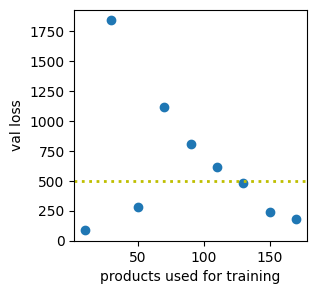

In [56]:
plt.figure(figsize=(3,3))
plt.scatter([item['x'] for item in standard_pq["min_val_losses"]],[item['y'] for item in standard_pq["min_val_losses"]])
plt.axhline(y=LOSS_REQUIRED, color='y', linestyle=':', linewidth=2)
#plt.ylim(0,5000)
plt.ylabel("val loss")
plt.xlabel("products used for training")
plt.show()

In [57]:
print(f"Loss_Score {standard_pq['min_val_losses'][-1]}")
print(f"Used Train Data {standard_pq['min_val_losses'][-1]['x']*0.8}")

Loss_Score {'y': 181.57858186609604, 'x': 170}
Used Train Data 136.0


In [58]:
model = NN()
model.model.load_state_dict(standard_pq['model_states'][-1])
data_not_used_for_training = all_products[standard_pq['used_train_data']:]
model.model.eval()
X = data_not_used_for_training[feature_columns]
y = data_not_used_for_training[target_column]

X = scaler.transform(X)
features_tensor = torch.tensor(X, dtype=torch.float)
target_tensor = torch.tensor(y.values, dtype=torch.float)

In [59]:
predictions = model.model(features_tensor)
predictions = predictions.squeeze()

In [60]:
loss_fn = nn.MSELoss(reduction='none')
loss_mse = loss_fn(target_tensor, predictions)
loss_mae = torch.abs(target_tensor - predictions)

In [61]:
loss_mse = loss_mse.tolist()

In [62]:
import numpy as np

def smooth_list(values, window_length):
    window = np.ones(int(window_length))/float(window_length)
    return np.convolve(values, window, 'same')

In [63]:
standard_pq['used_train_data']

136

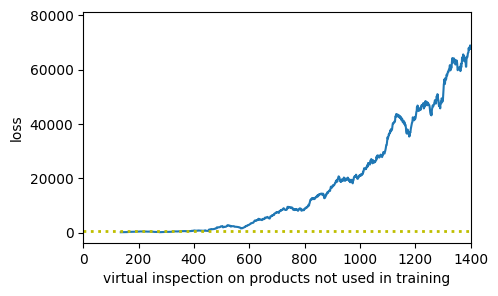

In [64]:
plt.figure(figsize=(5,3))
start = standard_pq['used_train_data']
amt_duft = len(data_not_used_for_training)
plt.plot(range(standard_pq['used_train_data'],amt_duft+standard_pq['used_train_data']),smooth_list(loss_mse,window_length=50))
plt.axhline(y=LOSS_REQUIRED, color='y', linestyle=':', linewidth=2)
plt.xlim(0,1400)
#plt.ylim(0,1000)
plt.ylabel("loss")
plt.xlabel("virtual inspection on products not used in training")
plt.show()